Environment setup

In [2]:
pip install wfdb numpy scipy matplotlib

   ---------------------------------------- 0.0/1.0 MB ? eta -:--:--
   ---------- ----------------------------- 0.3/1.0 MB ? eta -:--:--
   -------------------- ------------------- 0.5/1.0 MB 1.6 MB/s eta 0:00:01
   ------------------------------ --------- 0.8/1.0 MB 1.7 MB/s eta 0:00:01
   ---------------------------------------- 1.0/1.0 MB 1.5 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: C:\Users\Dell\AppData\Local\Programs\Python\Python313\python.exe -m pip install --upgrade pip


1. Load ECG Data (MIT-BIH record 100)

In [3]:
import wfdb  # For accessing MIT-BIH ECG data from PhysioNet.
import numpy as np   # For numerical operations.
import matplotlib.pyplot as plt # For plotting the ECG and detection results.

# Load record 100
record = wfdb.rdrecord('100', sampto=6500, pn_dir='mitdb')  # first 6500 samples
annotation = wfdb.rdann('100', 'atr', sampto=6500, pn_dir='mitdb') # annotation contains the true QRS complex labels (used later for evaluation).

# Use channel 0 (MLII)
ecg = record.p_signal[:, 0]  # ecg: Takes the first ECG lead (MLII).
fs = record.fs  # Sampling frequency (200 Hz) # fs: Sampling frequency = 200 Hz.

In [1]:
# Pan-Tompkins Filter DSP Analysis
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, freqz, tf2zpk, group_delay

# Sampling Frequency
fs = 200  # Hz (as in the Pan-Tompkins paper)

# ===============================
# Helper Plotting Functions
# ===============================
def plot_filter_analysis(b, a, fs, title_prefix):
    # Frequency response
    w, h = freqz(b, a, worN=8000)
    freqs = w * fs / (2 * np.pi)

    plt.figure(figsize=(14, 8))
    
    # Magnitude Response
    plt.subplot(2, 2, 1)
    plt.plot(freqs, 20 * np.log10(abs(h)))
    plt.title(f'{title_prefix} - Magnitude Response')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude (dB)')
    plt.grid()

    # Phase Response
    plt.subplot(2, 2, 2)
    plt.plot(freqs, np.unwrap(np.angle(h)))
    plt.title(f'{title_prefix} - Phase Response')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Phase (radians)')
    plt.grid()

    # Pole-Zero Plot
    z, p, k = tf2zpk(b, a)
    plt.subplot(2, 2, 3)
    plt.plot(np.real(z), np.imag(z), 'go', label='Zeros')
    plt.plot(np.real(p), np.imag(p), 'rx', label='Poles')
    plt.title(f'{title_prefix} - Pole-Zero Plot')
    plt.xlabel('Real')
    plt.ylabel('Imaginary')
    plt.axhline(0, color='black', linewidth=0.5)
    plt.axvline(0, color='black', linewidth=0.5)
    plt.grid()
    plt.axis('equal')
    plt.legend()

    # Group Delay
    w_gd, gd = group_delay((b, a))
    plt.subplot(2, 2, 4)
    plt.plot(w_gd * fs / (2 * np.pi), gd)
    plt.title(f'{title_prefix} - Group Delay')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Delay (samples)')
    plt.grid()

    plt.tight_layout()
    plt.show()

2. Implement Pan-Tompkins Stages

2.1 Bandpass Filter (Low-pass + High-pass)

Pan-Tompkins uses a bandpass filter (5–15 Hz) to remove unwanted noise:

Low-pass filter: Removes high-frequency noise like muscle artifacts.

High-pass filter: Removes low-frequency noise like baseline wander.

This filter helps isolate the QRS frequency band, improving detection reliability.

In [1]:
from scipy.signal import lfilter

def bandpass_filter(signal):
    # Low-pass filter
    low_b = [1, 0, -2, 0, 1]
    low_a = [1, -2, 1]
    low_passed = lfilter(low_b, low_a, signal)

    # High-pass filter
    high_b = [-1/32] + [0]*15 + [1, -1] + [0]*14 + [1/32]
    high_passed = lfilter(high_b, [1], low_passed)

    return high_passed


2.2 Derivative

Enhances the slope information of the QRS complex.

Detects sharp changes in signal—crucial because R-waves have steep edges.

Approximates the first derivative using a five-point central difference.

In [2]:
def derivative_filter(signal, fs=200):
    b = [1, 2, 0, -2, -1]
    return lfilter(b, [1], signal) * (1 / (8 * (1/fs)))


2.3 Squaring

Makes all values positive.

Amplifies larger values more than smaller ones.

Makes it easier to distinguish strong features (like QRS complexes) from noise.

In [7]:
def squaring(signal):
    return signal ** 2

2.4 Moving Window Integration

Integrates (averages) over a short window (~150 ms).

Captures both duration and area of the QRS complex.

Resulting waveform has wide peaks that correspond to QRS areas.

In [9]:
def moving_window_integration(signal, window_size=30):  # 150ms @ 200Hz
    window = np.ones(window_size) / window_size
    return np.convolve(signal, window, mode='same')

2.5 QRS Detection with Basic Thresholding (for now, simplified version without full adaptive logic)

Detects local maxima in the MWI output.

Applies a threshold (60% of max value by default).

Enforces a refractory period (200 ms) to avoid detecting multiple peaks per QRS.

This is a simplified version. The full algorithm uses adaptive dual thresholds and search-back logic, which we'll add in Task 4.

In [10]:
def detect_qrs(integrated, threshold_factor=0.6):
    threshold = threshold_factor * max(integrated)
    qrs_peaks = []
    refractory_period = int(0.2 * fs)  # 200ms

    last_peak = -refractory_period
    for i in range(1, len(integrated) - 1):
        if integrated[i] > threshold and integrated[i] > integrated[i-1] and integrated[i] > integrated[i+1]:
            if (i - last_peak) > refractory_period:
                qrs_peaks.append(i)
                last_peak = i
    return np.array(qrs_peaks)

3. Plot & Annotate Results

This plot:

Shows the raw ECG.

Overlays the MWI output.

Marks detected QRS complexes (red circles).

Marks true annotations from MIT-BIH (green Xs).

This helps visually evaluate detection performance.

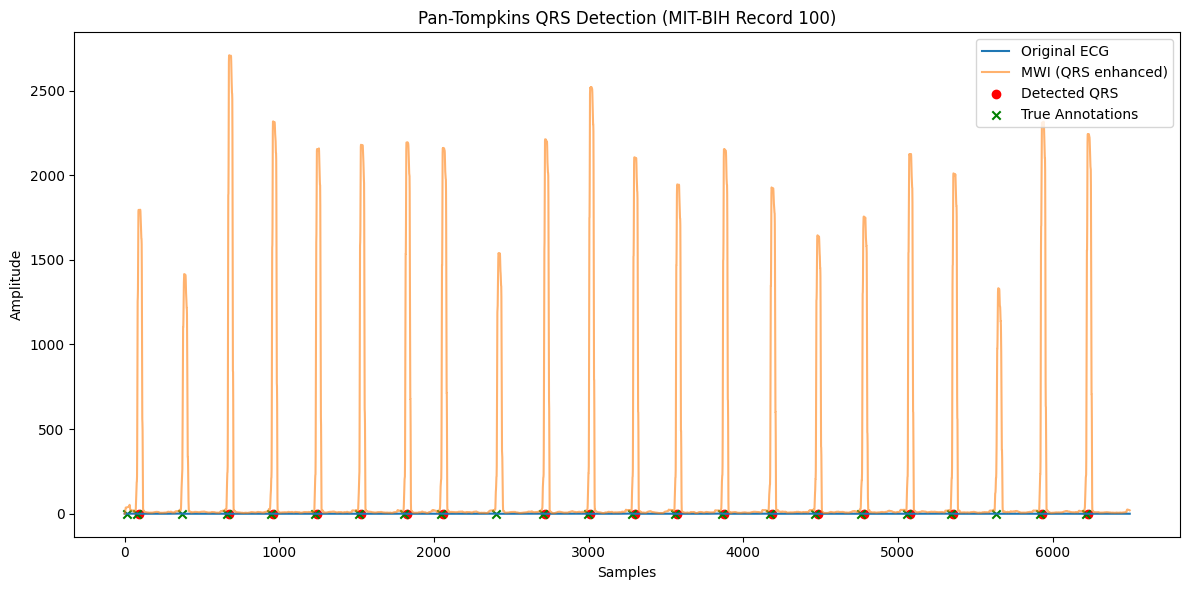

In [13]:
# Pipeline
filtered = bandpass_filter(ecg)
derivative = derivative_filter(filtered)
squared = squaring(derivative)
mwi = moving_window_integration(squared)

# QRS detection
detected_qrs = detect_qrs(mwi)

# Plot
plt.figure(figsize=(12, 6))
plt.plot(ecg, label='Original ECG')
plt.plot(mwi, label='MWI (QRS enhanced)', alpha=0.6)
plt.scatter(detected_qrs, ecg[detected_qrs], color='red', marker='o', label='Detected QRS')
plt.scatter(annotation.sample, ecg[annotation.sample], color='green', marker='x', label='True Annotations')
plt.title('Pan-Tompkins QRS Detection (MIT-BIH Record 100)')
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.legend()
plt.tight_layout()
plt.show()

Summary:
Stage Purpose: 

Bandpass Filter ->	Removes noise, isolates QRS band (5–15 Hz)

Derivative -> Extracts slope information (R-wave steepness)

Squaring -> Emphasizes large features (R-wave), suppresses small ones

Moving Window Integration -> Captures duration + energy of QRS

Thresholding + Refractory -> Basic QRS detection logic (to be improved)

In [16]:
# Cell 1: Import libraries and define analysis function

import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import freqz, group_delay, tf2zpk

def analyze_filter_separate_plots(b, a=1, fs=360, filter_name="Filter"):
    """
    Analyze a filter and plot magnitude response, phase response,
    group delay, and pole-zero plot in separate figures.
    """
    w, h = freqz(b, a, worN=8000)
    f = w * fs / (2 * np.pi)  # Convert rad/sample to Hz

    # Magnitude response
    plt.figure(figsize=(8,4))
    plt.plot(f, 20 * np.log10(np.abs(h)), 'b')
    plt.title(f'{filter_name} - Magnitude Response')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude (dB)')
    plt.grid()
    plt.show()

    # Phase response
    plt.figure(figsize=(8,4))
    plt.plot(f, np.unwrap(np.angle(h)), 'r')
    plt.title(f'{filter_name} - Phase Response')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Phase (radians)')
    plt.grid()
    plt.show()

    # Group delay
    plt.figure(figsize=(8,4))
    w_gd, gd = group_delay((b, a), fs=fs)
    plt.plot(w_gd, gd, 'g')
    plt.title(f'{filter_name} - Group Delay')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Group Delay (samples)')
    plt.grid()
    plt.show()

    # Pole-zero plot
    plt.figure(figsize=(6,6))
    zeros, poles, _ = tf2zpk(b, a)
    plt.title(f'{filter_name} - Pole-Zero Plot')
    plt.scatter(np.real(zeros), np.imag(zeros), marker='o', facecolors='none', edgecolors='b', label='Zeros')
    plt.scatter(np.real(poles), np.imag(poles), marker='x', color='r', label='Poles')
    plt.xlabel('Real')
    plt.ylabel('Imaginary')
    plt.grid()
    plt.axis('equal')
    plt.legend()
    plt.show()


Bandpass Filter (5-15HZ)

C:\Users\Dell\AppData\Local\Temp\ipykernel_26232\104134579.py:21: RuntimeWarning: divide by zero encountered in log10
  plt.plot(freqs, 20 * np.log10(abs(h)))
C:\Users\Dell\AppData\Local\Temp\ipykernel_26232\104134579.py:50: UserWarning: The filter's denominator is extremely small at frequencies [0.000],             around which a singularity may be present
  w_gd, gd = group_delay((b, a))


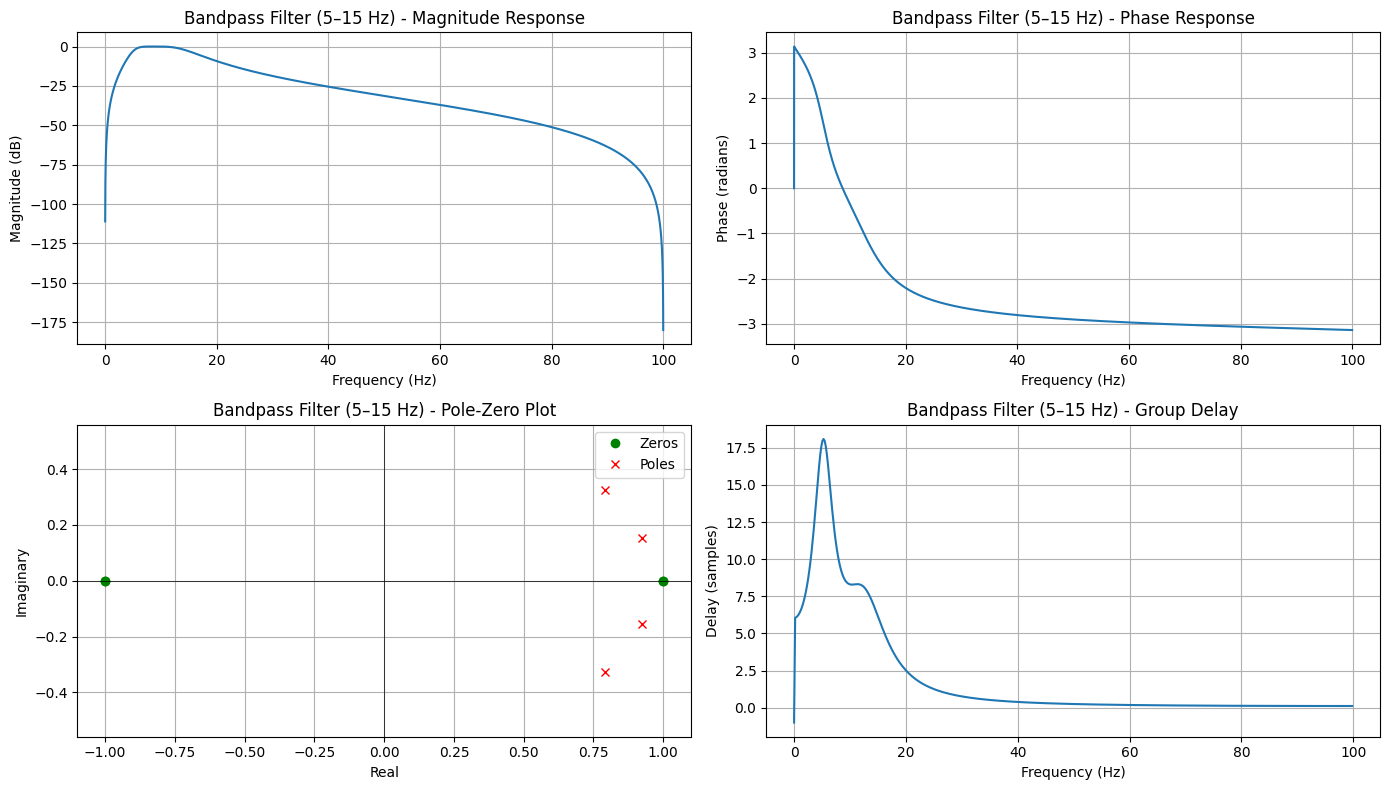

In [2]:
lowcut = 5
highcut = 15
order = 2
b_bp, a_bp = butter(order, [lowcut/(fs/2), highcut/(fs/2)], btype='band')
plot_filter_analysis(b_bp, a_bp, fs, 'Bandpass Filter (5–15 Hz)')

C:\Users\Dell\AppData\Local\Temp\ipykernel_932\3673486532.py:17: RuntimeWarning: divide by zero encountered in log10
  plt.plot(f, 20 * np.log10(np.abs(h)), 'b')


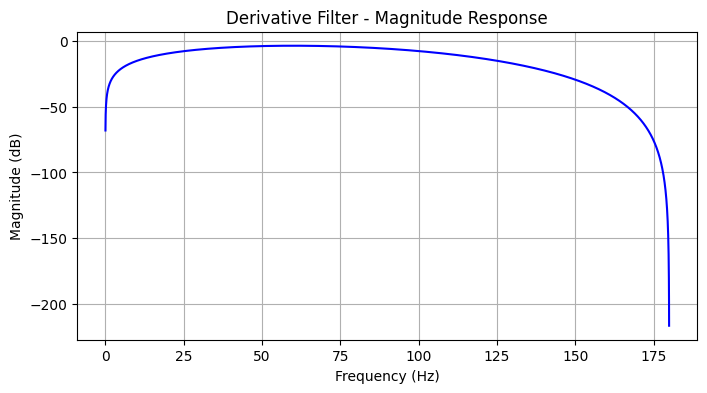

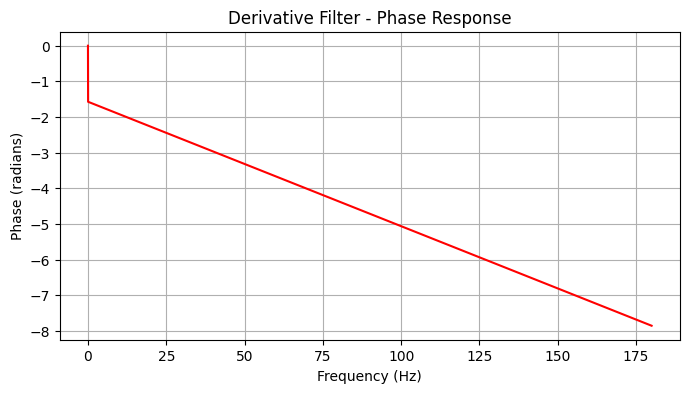

C:\Users\Dell\AppData\Local\Temp\ipykernel_932\3673486532.py:35: UserWarning: The group delay is singular at frequencies [0.000], setting to 0
  w_gd, gd = group_delay((b, a), fs=fs)


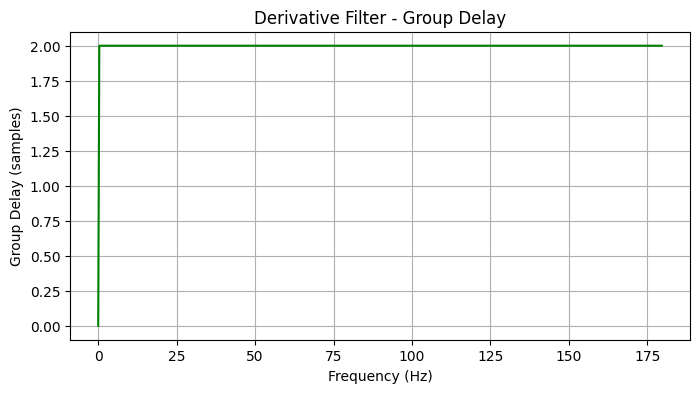

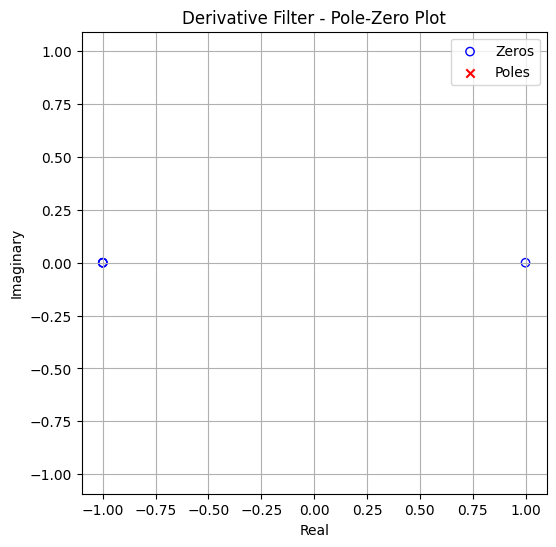

In [19]:
# Cell 3: Derivative Filter Analysis

b_derivative = np.array([-1, -2, 0, 2, 1]) / 8
a_derivative = np.array([1])

analyze_filter_separate_plots(b_derivative, a_derivative, fs=fs, filter_name="Derivative Filter")


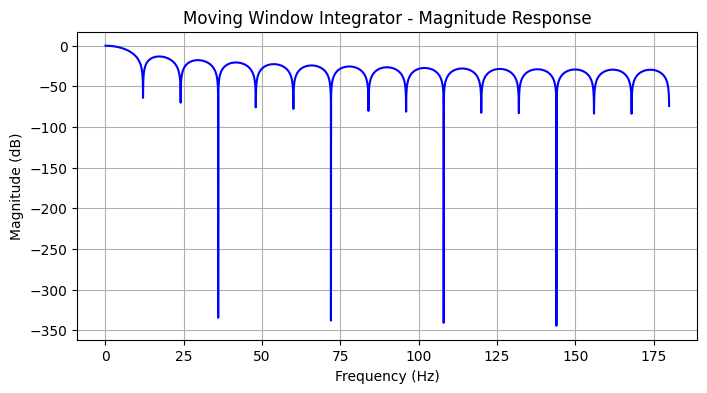

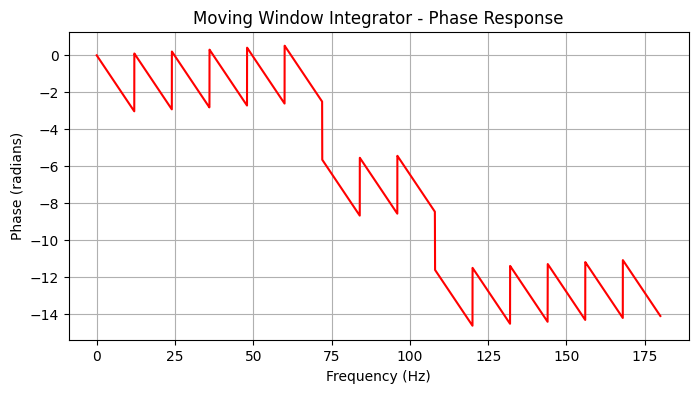

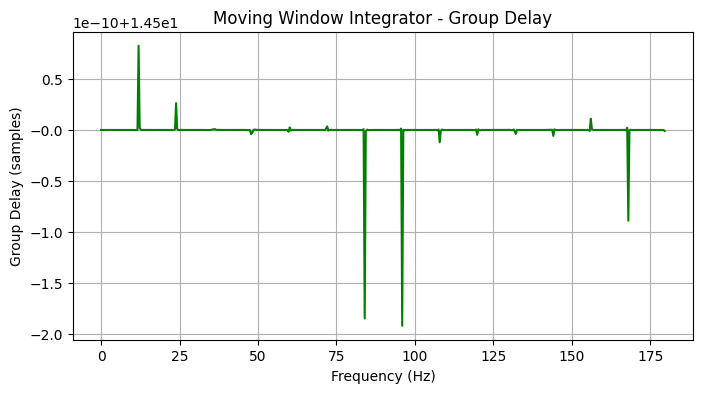

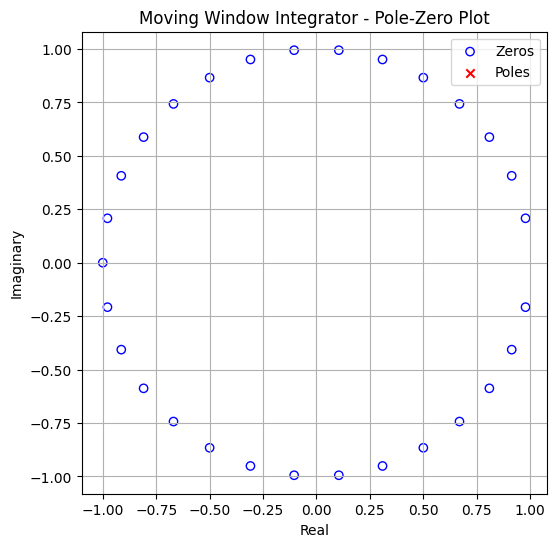

In [20]:
# Cell 4: Moving Window Integrator Analysis

N = 30
b_mwi = np.ones(N) / N
a_mwi = np.array([1])

analyze_filter_separate_plots(b_mwi, a_mwi, fs=fs, filter_name="Moving Window Integrator")
